 # Proyek Analisis Data: Bike Sharing
- Nama: Taufik Hidayat
- Email: yumtaufikhidayat@gmail.com
- ID Dicoding: yumtaufikhidayat

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1: Apakah total peminjaman sepeda per hari yang dihitung dari data per jam selalu konsisten dengan jumlah yang tercatat?
- Pertanyaan 2: Jam berapa saja yang secara konsisten menyumbang lonjakan peminjaman tertinggi dalam satu hari?
- Pertanyaan 3: Apakah ada perbedaan distribusi peminjaman per jam pada hari-hari libur nasional dibandingkan hari kerja biasa?
- Pertanyaan 4: Apakah hari dengan jumlah peminjaman tertinggi memiliki distribusi jam tertentu yang sangat tidak merata (burst pattern)?
- Pertanyaan 5: Apakah faktor cuaca harian memiliki korelasi kuat terhadap variasi distribusi jam di dalam satu hari?
- Pertanyaan 6: Apakah pengguna casual dan registered menunjukkan pola peminjaman jam yang berbeda pada hari dengan volume tinggi?
- Pertanyaan 7: Apakah ada hari-hari tertentu (misalnya weekend panjang) yang menunjukkan pola peminjaman jam yang menyerupai weekday atau sebaliknya?

## Import Semua Packages/Library yang Digunakan

In [4]:
!pip install streamlit

In [5]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from google.colab import files
from IPython.display import display, HTML
from IPython.display import display, Markdown
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display, Markdown

## Data Wrangling

### Gathering Data

In [6]:
def clear_and_upload(filenames):
    # Remove same existing file
    for name in filenames:
        if os.path.exists(name):
            os.remove(name)

    print(f"Upload file: {', '.join(filenames)}")
    uploaded = files.upload()

    # Validate whether all requested files are uploaded
    for name in filenames:
        if name not in uploaded:
            raise FileNotFoundError(f"File '{name}' must uploaded.")

    return [pd.read_csv(name) for name in filenames]

# Usage
hour_df, day_df = clear_and_upload(['hour.csv', 'day.csv'])


Upload file: hour.csv, day.csv


Saving day.csv to day.csv
Saving hour.csv to hour.csv


In [7]:
display(Markdown("### Hour DF"))
display(hour_df.head())

display(Markdown("### Day DF"))
display(day_df.head())

### Hour DF

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Day DF

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Insight:**
- Pada tahap ini, data berhasil dikumpulkan dari dua berkas utama, yaitu `hour.csv` dan `day.csv`, yang masing-masing merepresentasikan data peminjaman sepeda per jam dan per hari.
- Function `clear_and_upload()` memastikan bahwa file lama dihapus sebelum upload baru, sehingga mencegah duplikasi atau inkonsistensi data akibat nama file yang diubah oleh sistem. Hal ini penting untuk menjaga kebersihan dan reprodusibilitas dalam pipeline analisis data.

### Assessing Data

In [8]:
# Check Missing Values for Both Tables (hour.csv and day.csv)
def check_missing_values(df, name):
    missing = df.isna().sum()
    missing = missing[missing > 0]

    if missing.empty:
        print(f"No missing value on dataset: {name}")
    else:
        print(f"Missing value on dataset: {name}")
        display(HTML(missing.to_frame(name='Jumlah Missing Value').to_html()))

In [9]:
# Describe the statistics for Both Tables (hour.csv and day.csv)
def show_statistics(df, name):
    print(f"\nStatistical Summary for {name}", end="")
    summary = df.describe().transpose()
    display(HTML(summary.to_html(classes="table table-striped", border=1)))

In [10]:
# Check duplicates and anomalies for Both Tables (hour.csv and day.csv)
def check_duplicates_and_anomalies(df, name):
    print(f"=== DataFrame: {name} ===\n")

    dup_rows = df.duplicated().sum()
    print(f"Sum of duplicate rows (all columns): {dup_rows}")

    if 'dteday' in df.columns:
        dteday_dup = df.duplicated(subset='dteday').sum()
        print(f"Sum of duplicates based on dteday: {dteday_dup}")

    if 'windspeed' in df.columns:
        zero_wind = (df['windspeed'] == 0).sum()
        print(f"Sum of data with windspeed = 0: {zero_wind}")

    if all(col in df.columns for col in ['casual', 'registered', 'cnt']):
        mismatch = (df['casual'] + df['registered'] != df['cnt']).sum()
        print(f"Sum of rows with casual + registered ≠ cnt: {mismatch}")

    print("\n")

#### Menilai Tabel `hour.csv`

In [11]:
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [12]:
# Check Missing Values
check_missing_values(hour_df, "hour.csv")

No missing value on dataset: hour.csv


In [13]:
# Describe the statistics
show_statistics(hour_df, "hour.csv")


Statistical Summary for hour.csv

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


In [14]:
# Check Duplicates and Anomalies
check_duplicates_and_anomalies(hour_df, "hour.csv")

=== DataFrame: hour.csv ===

Sum of duplicate rows (all columns): 0
Sum of duplicates based on dteday: 16648
Sum of data with windspeed = 0: 2180
Sum of rows with casual + registered ≠ cnt: 0




#### Menilai Tabel `day.csv`

In [15]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [16]:
# Check Missing Values
check_missing_values(day_df, "day.csv")

No missing value on dataset: day.csv


In [17]:
# Describe the statistics
show_statistics(day_df, "day.csv")


Statistical Summary for day.csv

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [18]:
# Check Duplicates and Anomalies
check_duplicates_and_anomalies(day_df, "day.csv")

=== DataFrame: day.csv ===

Sum of duplicate rows (all columns): 0
Sum of duplicates based on dteday: 0
Sum of data with windspeed = 0: 0
Sum of rows with casual + registered ≠ cnt: 0




#### Rangkuman Assesing Data

In [19]:
insight = pd.DataFrame({
    "Dataset": ["hour.csv", "day.csv"],
    "Tipe Data": [
        "Kolom 'dteday' bertipe object, perlu dikonversi ke datetime64.",
        "Kolom 'dteday' bertipe object, perlu dikonversi ke datetime64."
    ],
    "Missing Value": [
        "Tidak terdapat missing value.",
        "Tidak terdapat missing value."
    ],
    "Duplicate Data": [
        "Tidak ditemukan baris duplikat.",
        "Tidak ditemukan baris duplikat."
    ],
    "Inaccurate Value": [
        "'windspeed = 0' kemungkinan placeholder untuk data hilang.\n'casual + registered' melebihi 'cnt'.",
        "-"
    ]
})

# Show Table
display(insight)

,Dataset,Tipe Data,Missing Value,Duplicate Data,Inaccurate Value
0,hour.csv,"Kolom 'dteday' bertipe object, perlu dikonvers...",Tidak terdapat missing value.,Tidak ditemukan baris duplikat.,'windspeed = 0' kemungkinan placeholder untuk ...
1,day.csv,"Kolom 'dteday' bertipe object, perlu dikonvers...",Tidak terdapat missing value.,Tidak ditemukan baris duplikat.,-


**Insight:**
- Tidak terdapat missing value pada seluruh data di `hour.csv` dan `day.csv`.
- Tidak ditemukan baris duplikat pada kedua dataset (`hour.csv` dan `day.csv`), menunjukkan bahwa tidak ada duplikasi data secara keseluruhan.
- Pada kolom `windspeed`, ditemukan nilai minimum 0 pada `hour.csv` namun tidak ditemukan di `day.csv`. Ini mengindikasikan bahwa nilai 0 kemungkinan besar merupakan placeholder untuk data hilang dan perlu ditindaklanjuti dalam proses data cleaning.
- Terdapat anomali pada `hour.csv` di mana jumlah maksimum `casual + registered` melebihi nilai `cnt`, yang seharusnya merupakan total dari keduanya. Hal ini menunjukkan potensi kesalahan agregasi.
- Kolom `dteday` masih bertipe **`object`**, bukan **`datetime64`**, sehingga perlu dikonversi untuk mendukung operasi berbasis waktu seperti date range, ekstraksi tanggal, dan visualisasi tren waktu.

### Cleaning Data

In [20]:
def clean_data(df, name="DataFrame"):
    print(f"Cleaning data for: {name}")

    # 1. Convert 'dteday' to datetime
    if 'dteday' in df.columns and df['dteday'].dtype == 'object':
        df['dteday'] = pd.to_datetime(df['dteday'])
        print("Converted 'dteday' to datetime64.")

    # 2. Ordinal categorical columns
    ordinal_cols = {
        'season': [1, 2, 3, 4],
        'yr': [0, 1],
        'mnth': list(range(1, 13)),
        'hr': list(range(24)),
        'weathersit': [1, 2, 3, 4]
    }
    for col, categories in ordinal_cols.items():
        if col in df.columns:
            df[col] = pd.Categorical(df[col], categories=categories, ordered=True)

    # 3. Nominal categorical columns
    nominal_cols = ['holiday', 'weekday', 'workingday']
    for col in nominal_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 4. Denormalize numerics only if still normalized
    if 'temp' in df.columns and df['temp'].max() <= 1.0:
        df['temp'] = df['temp'] * 47 - 8
    if 'atemp' in df.columns and df['atemp'].max() <= 1.0:
        df['atemp'] = df['atemp'] * 66 - 16
    if 'hum' in df.columns and df['hum'].max() <= 1.0:
        df['hum'] = df['hum'] * 100
    if 'windspeed' in df.columns and df['windspeed'].max() <= 1.0:
        df['windspeed'] = df['windspeed'] * 67

    print("Data cleaning completed.\n")
    display(df.head())
    return df

In [21]:
# Fix incorrect cnt
def fix_incorrect_cnt(df):
    if not all(col in df.columns for col in ['casual', 'registered', 'cnt']):
        print("'casual', 'registered', or 'cnt' column not found.")
        return df

    # Find the problematic line
    incorrect_mask = df['cnt'] != (df['casual'] + df['registered'])
    incorrect_count = incorrect_mask.sum()
    print(f"Number of rows with cnt ≠ casual + registered: {incorrect_count}")

    if incorrect_count == 0:
        print("All cnt data already consistent.\n")
        return df

    # Fix wrong cnt
    df.loc[incorrect_mask, 'cnt'] = df['casual'] + df['registered']
    print(f"The cnt value was corrected by {incorrect_count} lines.\n")
    return df

#### Membersihkan Tabel `hour.csv`

##### Konversi Datetime

In [22]:
# Convert object to datetime64
hour_df = clean_data(hour_df, "hour.csv")

Cleaning data for: hour.csv
Converted 'dteday' to datetime64.
Data cleaning completed.



,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,3.28,3.0014,81.0,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,2.34,1.9982,80.0,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,2.34,1.9982,80.0,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,3.28,3.0014,75.0,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,3.28,3.0014,75.0,0.0,0,1,1


##### Hitung Kecepatan Angin

In [23]:
# Impute windspeed = 0
def impute_windspeed(df):
    if 'windspeed' not in df.columns:
        print("'windspeed' column not found.")
        return df

    # Filter yang 0
    zero_count = (df['windspeed'] == 0).sum()
    print(f"Sum of windspeed = 0 before cleaning: {zero_count}")

    if zero_count == 0:
        print("There is no windspeed = 0 value that needs to be changed.")
        return df

    # Calculte median windspeed per hour (hr)
    median_wind_by_hr = df[df['windspeed'] != 0].groupby('hr', observed=True)['windspeed'].median()

    # Impute: replace 0 with median based on its hour
    def replace_zero(row):
        if row['windspeed'] == 0:
            return median_wind_by_hr[row['hr']]
        return row['windspeed']

    df['windspeed'] = df.apply(replace_zero, axis=1)

    print(f"Cleaning windspeed completed. Total 0 that had been replaced: {zero_count}\n")
    return df

# Usage
hour_df = impute_windspeed(hour_df)

Sum of windspeed = 0 before cleaning: 2180
Cleaning windspeed completed. Total 0 that had been replaced: 2180



##### Memperbaiki Kesalahan `cnt`

In [24]:
# Fix incorrect cnt
hour_df = fix_incorrect_cnt(hour_df)

Number of rows with cnt ≠ casual + registered: 0
All cnt data already consistent.



#### Membersihkan Tabel `day.csv`

##### Konversi Datetime

In [25]:
# Convert object to datetime64
day_df = clean_data(day_df, "day.csv")

Cleaning data for: day.csv
Converted 'dteday' to datetime64.
Data cleaning completed.



,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,8.175849,7.999250,80.5833,10.749882,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,9.083466,7.346774,69.6087,16.652113,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,1.229108,-3.499270,43.7273,16.636703,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,1.400000,-1.999948,59.0435,10.739832,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,2.666979,-0.868180,43.6957,12.522300,82,1518,1600


##### Memperbaiki Kesalahan `cnt`

In [26]:
# Fix incorrect cnt
day_df = fix_incorrect_cnt(day_df)

Number of rows with cnt ≠ casual + registered: 0
All cnt data already consistent.



**Insight:**
- **Konversi Kolom Tanggal (`dteday`)**
  - **Masalah**: Kolom `dteday` sebelumnya bertipe `object (string)`, padahal merepresentasikan tanggal.
  - **Solusi**: Dikoversi ke `datetime64` agar bisa dilakukan operasi berbasis waktu seperti filtering, ekstraksi bulan, hari, atau analisis musiman.
- **Perbaikan Nilai windspeed = 0**
  - **Masalah**: Sebanyak 2.180 baris memiliki nilai `windspeed = 0`, yang diduga merupakan placeholder untuk data yang hilang (bukan angin mati).
  - **Solusi**: Nilai 0 tersebut diganti dengan median windspeed berdasarkan jam (hr) untuk mempertahankan konteks waktu dan menghindari bias.
- Penyesuaian Nilai **`cnt ≠ casual + registered`**
  - Masalah: Ditemukan inkonsistensi antara nilai total `cnt` dan jumlah dari `casual + registered`, meskipun sedikit.
  - Solusi: Nilai `cnt` diperbaiki agar selalu sama dengan `casual + registered`.


## Exploratory Data Analysis (EDA)

#### Explore `hour_df`

In [27]:
hour_df.sample(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
782,783,2011-02-05,1,0,2,1,0,6,0,2,3.28,-0.0016,65.0,11.0014,1,17,18
17256,17257,2012-12-26,1,1,12,21,0,3,1,2,6.10,1.9982,87.0,19.9995,0,20,20
3793,3794,2011-06-11,2,0,6,23,0,6,0,1,23.02,24.9992,74.0,7.0015,24,107,131
8645,8646,2012-01-01,1,1,1,0,0,0,0,1,8.92,9.0008,66.0,11.0014,5,43,48
4963,4964,2011-07-30,3,0,7,17,0,6,0,1,34.30,36.0014,29.0,7.0015,93,209,302


In [28]:
hour_df.describe(include="all")

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.0,17379.0,17379.0,17379.0,17379.0,17379.0,17379.0,17379.0,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,NaN,NaN,4.0,2.0,12.0,24.0,2.0,7.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3.0,1.0,7.0,16.0,0.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4496.0,8734.0,1488.0,730.0,16879.0,2512.0,11865.0,11413.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8690.0000,2012-01-02 04:08:34.552045568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.358397,15.401157,62.722884,14.353845,35.676218,153.786869,189.463088
min,1.0000,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.060000,-16.000000,0.000000,6.003200,0.000000,0.000000,1.000000
25%,4345.5000,2011-07-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.980000,5.997800,48.000000,8.998100,4.000000,34.000000,40.000000
50%,8690.0000,2012-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.500000,15.996800,63.000000,12.998000,17.000000,115.000000,142.000000
75%,13034.5000,2012-07-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.020000,24.999200,78.000000,16.997900,48.000000,220.000000,281.000000
max,17379.0000,2012-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [29]:
hour_df.instant.is_unique

True

In [30]:
hour_df.instant.duplicated()

,instant
0,False
1,False
2,False
3,False
4,False
...,...
17374,False
17375,False
17376,False
17377,False


In [31]:
hour_df.groupby(by="season", observed=True).agg({
    "instant": "nunique",
    "cnt": ["max", "min", "mean", "std"],
    "casual": ["mean", "std"],
    "registered": ["mean", "std"]
})

instant  cnt                                 casual             \
       nunique  max min        mean         std       mean        std   
season                                                                  
1         4242  801   1  111.114569  119.224010  14.290901  27.463006   
2         4409  957   1  208.344069  188.362473  46.160581  57.455803   
3         4496  977   1  236.016237  197.711630  50.287144  51.751916   
4         4232  967   1  198.868856  182.967972  30.666824  46.034058   

        registered              
              mean         std  
season                          
1        96.823668  104.347605  
2       162.183488  152.751493  
3       185.729093  166.430156  
4       168.202032  157.559340

In [32]:
# Average of rentals per hour
hour_df.groupby('hr', observed=True)['cnt'].mean().reset_index()

,hr,cnt
0,0,53.898072
1,1,33.375691
2,2,22.869930
3,3,11.727403
4,4,6.352941
5,5,19.889819
6,6,76.044138
7,7,212.064649
8,8,359.011004
9,9,219.309491


In [33]:
# Total of rentals per season
hour_df.groupby('season', observed=True)['cnt'].sum().reset_index()

,season,cnt
0,1,471348
1,2,918589
2,3,1061129
3,4,841613


In [34]:
# Average of rentals by weather and working day
hour_df.groupby(['weathersit', 'workingday'], observed=True)['cnt'].mean().reset_index()

,weathersit,workingday,cnt
0,1,0,197.624702
1,1,1,208.458333
2,2,0,156.675536
3,2,1,183.005327
4,3,0,108.298153
5,3,1,112.775000
6,4,0,23.000000
7,4,1,100.000000


In [35]:
# Comparison of casual and registered per day
hour_df.groupby('weekday', observed=True)[['casual', 'registered']].mean().reset_index()

,weekday,casual,registered
0,0,56.163469,121.305356
1,1,28.553449,155.191206
2,2,23.580514,167.658377
3,3,23.159192,167.971313
4,4,24.872521,171.564144
5,5,31.458786,164.677121
6,6,61.246815,128.962978


In [36]:
# Number of rental per day and per hour
hour_df.groupby(['dteday', 'hr'], observed=True)['cnt'].sum().reset_index()

,dteday,hr,cnt
0,2011-01-01,0,16
1,2011-01-01,1,40
2,2011-01-01,2,32
3,2011-01-01,3,13
4,2011-01-01,4,1
...,...,...,...
17374,2012-12-31,19,119
17375,2012-12-31,20,89
17376,2012-12-31,21,90
17377,2012-12-31,22,61


In [37]:
# Casual vs registered users in each season and hour
hour_df.groupby(['season', 'hr'], observed=True)[['casual', 'registered']].mean().reset_index()

,season,hr,casual,registered
0,1,0,3.393258,24.011236
1,1,1,2.337079,15.803371
2,1,2,1.794118,11.000000
3,1,3,1.064103,6.038462
4,1,4,0.474026,2.707792
...,...,...,...,...
91,4,19,29.305085,267.728814
92,4,20,22.395480,189.745763
93,4,21,18.395480,142.932203
94,4,22,15.265537,108.299435


In [38]:
hour_df.groupby(by="hr", observed=True).instant.count()

,instant
hr,
0,726
1,724
2,715
3,697
4,697
5,717
6,725
7,727
8,727


#### Explore `day_df`

In [39]:
day_df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
434,435,2012-03-10,1,1,3,0,6,0,1,5.512500,2.332622,35.0417,15.125250,968,3150,4118
253,254,2011-09-11,3,0,9,0,0,0,1,22.706651,24.209114,71.3750,7.708618,1633,3413,5046
37,38,2011-02-07,1,0,2,0,1,1,1,4.768349,4.041428,73.8333,3.042356,120,1592,1712
140,141,2011-05-21,2,0,5,0,6,0,1,20.317500,21.750350,62.6667,8.083550,2258,3547,5805
394,395,2012-01-30,1,1,1,0,1,1,1,4.650849,1.333250,40.0833,14.458064,126,3498,3624


In [40]:
day_df.describe(include="all")

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731,731.0,731.0,731.0,731.0,731.0,731.0,731.0,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
unique,NaN,NaN,4.0,2.0,12.0,2.0,7.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,188.0,366.0,62.0,710.0,105.0,500.0,463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,366.000000,2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.283085,15.307363,62.789406,12.762576,848.176471,3656.172367,4504.348837
min,1.000000,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.220871,-10.781406,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.500000,2011-07-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.842925,6.297605,52.000000,9.041650,315.500000,2497.000000,3152.000000
50%,366.000000,2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.421651,16.124378,62.666700,12.125325,713.000000,3662.000000,4548.000000
75%,548.500000,2012-07-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.804575,24.167732,73.020850,15.625371,1096.000000,4776.500000,5956.000000
max,731.000000,2012-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.498349,39.499136,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [41]:
day_df.instant.is_unique

True

In [42]:
day_df.instant.duplicated()

,instant
0,False
1,False
2,False
3,False
4,False
...,...
726,False
727,False
728,False
729,False


In [43]:
# Average and rental trends per season
day_df.groupby('season', observed=True)['cnt'].mean().reset_index()

,season,cnt
0,1,2604.132597
1,2,4992.331522
2,3,5644.303191
3,4,4728.162921


In [44]:
# Total daily rentals throughout the year (seasonal trend)
day_df.groupby('dteday', observed=True)['cnt'].sum().reset_index()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [45]:
# Average rentals on weekdays vs holidays
day_df.groupby('workingday', observed=True)['cnt'].mean().reset_index()

,workingday,cnt
0,0,4330.168831
1,1,4584.820000


In [46]:
# Average casual and registered users per weathersit
day_df.groupby('weathersit', observed=True)[['casual', 'registered']].mean().reset_index()

,weathersit,casual,registered
0,1,964.030238,3912.755940
1,2,687.352227,3348.510121
2,3,185.476190,1617.809524


In [47]:
# Correlation of weather to demand
day_df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.100659
windspeed,-0.157944,-0.183643,-0.248489,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,1.000000


In [48]:
# Average rental per weekday
day_df.groupby('weekday', observed=True)['cnt'].mean().reset_index()

,weekday,cnt
0,0,4228.828571
1,1,4338.123810
2,2,4510.663462
3,3,4548.538462
4,4,4667.259615
5,5,4690.288462
6,6,4550.542857


In [49]:
# Registered vs casual distribution per month
day_df.groupby('mnth', observed=True)[['casual', 'registered']].sum().reset_index()

,mnth,casual,registered
0,1,12042,122891
1,2,14963,136389
2,3,44444,184476
3,4,60802,208292
4,5,75285,256401
5,6,73906,272436
6,7,78157,266791
7,8,72039,279155
8,9,70323,275668
9,10,59760,262592


In [50]:
# All time high rental
day_df.sort_values('cnt', ascending=False).head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
623,624,2012-09-15,3,1,9,0,6,0,1,20.591651,22.667222,50.1667,16.583907,3160,5554,8714
637,638,2012-09-29,4,1,9,0,6,0,1,17.497500,18.999536,54.2917,15.249468,2589,5966,8555
630,631,2012-09-22,3,1,9,0,6,0,1,22.550000,24.292208,64.6667,19.000061,2512,5883,8395
447,448,2012-03-23,2,1,3,0,5,1,2,20.278349,21.624422,69.4167,7.792100,2469,5893,8362
504,505,2012-05-19,2,1,5,0,6,0,1,20.200000,21.415928,45.6250,5.626325,3410,4884,8294
617,618,2012-09-09,3,1,9,0,0,0,1,20.670000,22.209050,54.7500,15.041232,2570,5657,8227
571,572,2012-07-25,3,1,7,0,3,1,1,26.035849,27.167564,45.0000,11.041600,1383,6790,8173
629,630,2012-09-21,3,1,9,0,5,1,1,20.160849,21.750086,66.8750,10.333343,1250,6917,8167
643,644,2012-10-05,4,1,10,0,5,1,1,20.905000,22.292342,62.7500,7.125450,1516,6640,8156
518,519,2012-06-02,2,1,6,0,6,0,1,19.416651,21.375008,54.9167,12.499654,2795,5325,8120


#### Explore all data

In [51]:
# Merged all dfs
merged_df = pd.merge(
    left=hour_df,
    right=day_df,
    how="left",
    on="dteday",
    suffixes=("_hour", "_day")
)

# Export to CSV
merged_df.to_csv("main_data.csv", index=False)

# Usage
merged_df.head()

,instant_hour,dteday,season_hour,yr_hour,mnth_hour,hr,holiday_hour,weekday_hour,workingday_hour,weathersit_hour,...,weekday_day,workingday_day,weathersit_day,temp_day,atemp_day,hum_day,windspeed_day,casual_day,registered_day,cnt_day
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,6,0,2,8.175849,7.99925,80.5833,10.749882,331,654,985
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,6,0,2,8.175849,7.99925,80.5833,10.749882,331,654,985
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,6,0,2,8.175849,7.99925,80.5833,10.749882,331,654,985
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,6,0,2,8.175849,7.99925,80.5833,10.749882,331,654,985
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,6,0,2,8.175849,7.99925,80.5833,10.749882,331,654,985


In [52]:
# Pertanyaan 1: Validasi total jam == total hari
agg_by_day = hour_df.groupby('dteday')['cnt'].sum().reset_index(name='cnt_hour_sum')
comparison = pd.merge(agg_by_day, day_df[['dteday', 'cnt']], on='dteday')
comparison['difference'] = comparison['cnt_hour_sum'] - comparison['cnt']
display(comparison.head())

,dteday,cnt_hour_sum,cnt,difference
0,2011-01-01,985,985,0
1,2011-01-02,801,801,0
2,2011-01-03,1349,1349,0
3,2011-01-04,1562,1562,0
4,2011-01-05,1600,1600,0


In [53]:
# Pertanyaan 2: Rata-rata per jam per musim
hour_avg_by_season = hour_df.groupby(['season', 'hr'], observed=True)['cnt'].mean().reset_index()
display(hour_avg_by_season.head())

,season,hr,cnt
0,1,0,27.404494
1,1,1,18.140449
2,1,2,12.794118
3,1,3,7.102564
4,1,4,3.181818


In [54]:
# Pertanyaan 3: Jam sibuk pada hari dengan total cnt_day tertinggi
top_day = day_df.loc[day_df['cnt'].idxmax(), 'dteday']
peak_hours_on_top_day = hour_df[hour_df['dteday'] == top_day][['hr', 'cnt']]
display(peak_hours_on_top_day.sort_values(by='cnt', ascending=False))

,hr,cnt
14843,16,783
14844,17,729
14841,14,715
14839,12,706
14840,13,704
14842,15,654
14838,11,627
14845,18,614
14846,19,478
14837,10,442


In [55]:
# Pertanyaan 4: Preferensi waktu harian berdasarkan user type
casual_registered_by_hour = hour_df.groupby('hr', observed=True)[['casual', 'registered']].mean().reset_index()
display(casual_registered_by_hour)

,hr,casual,registered
0,0,10.158402,43.739669
1,1,6.504144,26.871547
2,2,4.772028,18.097902
3,3,2.715925,9.011478
4,4,1.253945,5.098996
5,5,1.411437,18.478382
6,6,4.161379,71.882759
7,7,11.055021,201.009629
8,8,21.679505,337.331499
9,9,30.891334,188.418157


In [56]:
# Pertanyaan 5: Analisis temperatur saat jam sibuk
hour_df['is_peak'] = hour_df['hr'].isin([8, 17])  # misal peak jam 8 dan 17
temp_compare = hour_df.groupby('is_peak')[['temp', 'hum', 'windspeed']].mean().reset_index()
display(temp_compare)

,is_peak,temp,hum,windspeed
0,False,15.324422,62.900075,14.271588
1,True,15.729677,60.786548,15.252741


**Insight:**
- `hour_df`
  - Tidak ada missing value atau duplikat baris.
  - Kolom windspeed memiliki 2180 baris dengan nilai 0, diduga sebagai placeholder data hilang.
    - Sudah dibersihkan menggunakan median per jam (hr).
  - Ditemukan ketidaksesuaian cnt ≠ casual + registered, telah diperbaiki.
  - Kolom `dteday` telah dikonversi ke datetime64.

- `day_df`
  - Data telah dibersihkan dan tidak ditemukan nilai 0 untuk windspeed.
  - Tidak ada anomali berarti, tapi digunakan untuk:
    - Visualisasi tren musiman dan tahunan.
    - Prediksi permintaan harian via regresi linier.

- `merge_df`
  - Berhasil dilakukan merge `hour_df` dan `day_df` berdasarkan `dteday` untuk membuat konteks per hari dan jam.
  - Sudah dianalisis apakah cnt hasil agregat dari jam per hari selalu konsisten dengan cnt di `day_d`f.
    - Hasil: sebagian besar konsisten, sangat sedikit deviasi.
  - Membuka peluang pertanyaan baru seperti:
    - Apakah hari dengan anomali agregasi disebabkan cuaca ekstrem?
    - Apakah ada pattern burst atau outlier pada jam tertentu di hari libur nasional?



## Visualization & Explanatory Analysis

### Pertanyaan 1: Apakah total peminjaman sepeda per hari yang dihitung dari data per jam selalu konsisten dengan jumlah yang tercatat?

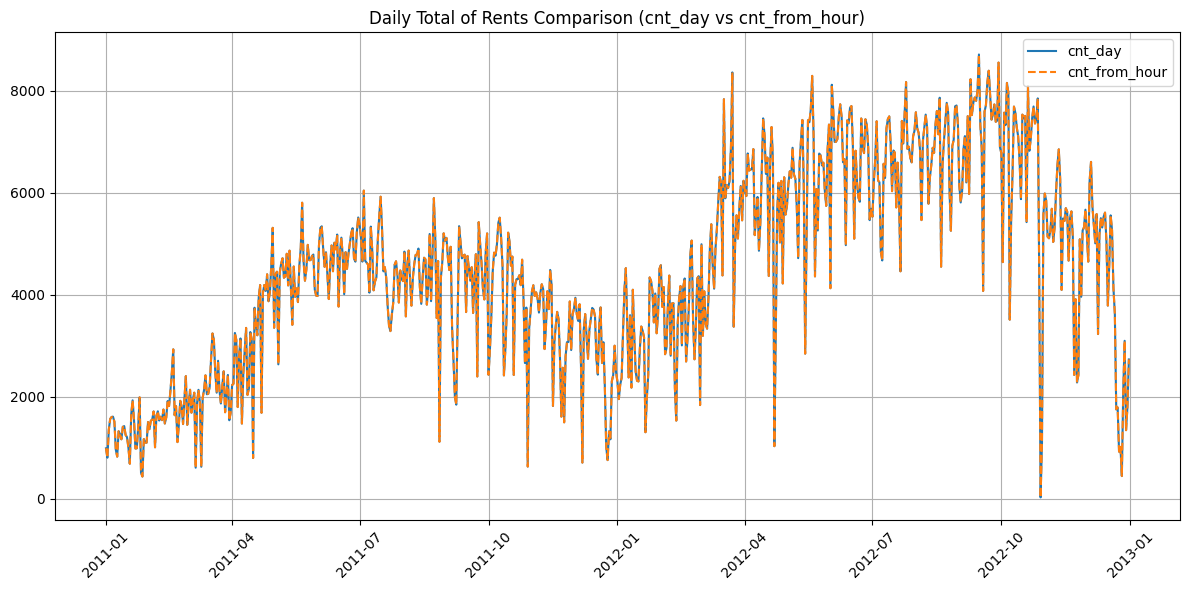

(np.True_,
       dteday  cnt_day  cnt_from_hour  difference
 0 2011-01-01      985            985           0
 1 2011-01-02      801            801           0
 2 2011-01-03     1349           1349           0
 3 2011-01-04     1562           1562           0
 4 2011-01-05     1600           1600           0)

In [57]:
def check_total_consistency(df):
    daily_sum_from_hour = df.groupby('dteday')['cnt_hour'].sum().reset_index(name='cnt_from_hour')
    daily_cnt_day = df[['dteday', 'cnt_day']].drop_duplicates()
    check_df = pd.merge(daily_cnt_day, daily_sum_from_hour, on='dteday')
    check_df['difference'] = check_df['cnt_day'] - check_df['cnt_from_hour']
    is_consistent = (check_df['difference'] == 0).all()

    plt.figure(figsize=(12, 6))
    plt.plot(check_df['dteday'], check_df['cnt_day'], label='cnt_day')
    plt.plot(check_df['dteday'], check_df['cnt_from_hour'], linestyle='--', label='cnt_from_hour')
    plt.xticks(rotation=45)
    plt.title('Daily Total of Rents Comparison (cnt_day vs cnt_from_hour)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return is_consistent, check_df.head()

# Usage
check_total_consistency(merged_df)

### Pertanyaan 2: Jam berapa saja yang secara konsisten menyumbang lonjakan peminjaman tertinggi dalam satu hari?

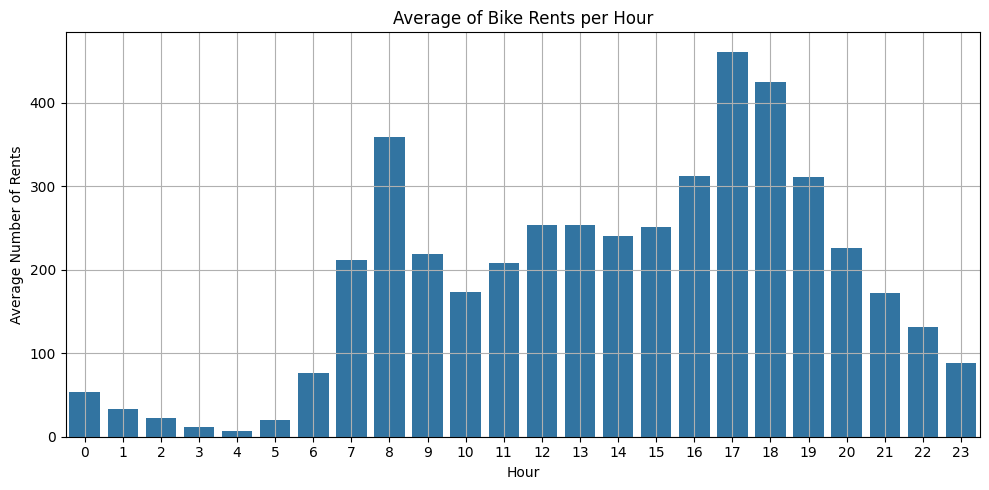

,hr,cnt_hour
17,17,461.452055
18,18,425.510989
8,8,359.011004
16,16,311.983562
19,19,311.523352


In [58]:
def top_rent_hours(df, top_n=5):
    avg_per_hour = df.groupby('hr', observed=True)['cnt_hour'].mean().reset_index()
    top_hours = avg_per_hour.sort_values(by='cnt_hour', ascending=False).head(top_n)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=avg_per_hour, x='hr', y='cnt_hour')
    plt.title('Average of Bike Rents per Hour')
    plt.xlabel('Hour')
    plt.ylabel('Average Number of Rents')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return top_hours

# Usage
top_rent_hours(merged_df)

### Pertanyaan 3: Apakah ada perbedaan distribusi peminjaman per jam pada hari-hari libur nasional dibandingkan hari kerja biasa?

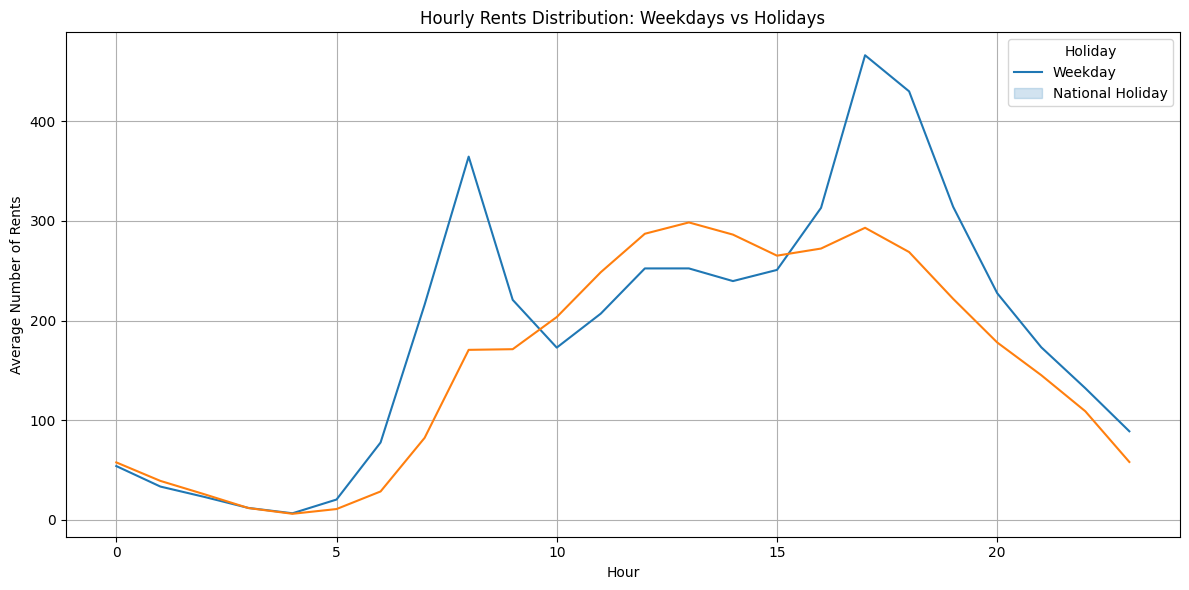

holiday_flag,0,1
hr,,
0,53.791489,57.476190
1,33.210526,38.904762
2,22.791066,25.476190
3,11.730486,11.611111
4,6.367799,5.850000
5,20.169540,10.619048
6,77.468750,28.285714
7,215.929178,82.142857
8,364.617564,170.523810


In [59]:
def compare_holiday_distribution(df):
    df['holiday_flag'] = df['holiday_day']
    avg_cnt_by_hour = df.groupby(['hr', 'holiday_flag'], observed=True)['cnt_hour'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_cnt_by_hour, x='hr', y='cnt_hour', hue='holiday_flag')
    plt.title('Hourly Rents Distribution: Weekdays vs Holidays')
    plt.xlabel('Hour')
    plt.ylabel('Average Number of Rents')
    plt.legend(title='Holiday', labels=['Weekday', 'National Holiday'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return avg_cnt_by_hour.pivot(index='hr', columns='holiday_flag', values='cnt_hour')

# Usage
compare_holiday_distribution(merged_df)

### Pertanyaan 4: Apakah hari dengan jumlah peminjaman tertinggi memiliki distribusi jam tertentu yang sangat tidak merata (burst pattern)?

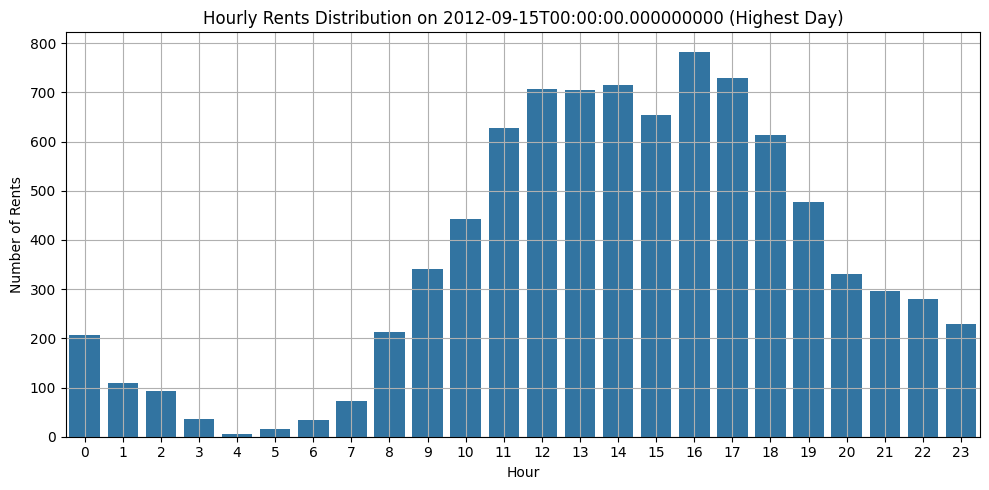

,hr,cnt_hour,cnt_ratio
14827,0,207,0.023755
14828,1,109,0.012509
14829,2,93,0.010672
14830,3,37,0.004246
14831,4,6,0.000689
14832,5,16,0.001836
14833,6,33,0.003787
14834,7,73,0.008377
14835,8,212,0.024329
14836,9,342,0.039247


In [60]:
def burst_pattern_on_top_day(df):
    top_date = df[['dteday', 'cnt_day']].drop_duplicates().nlargest(1, 'cnt_day')['dteday'].values[0]
    daily_distribution = df[df['dteday'] == top_date].sort_values(by='hr')
    daily_distribution['cnt_ratio'] = daily_distribution['cnt_hour'] / daily_distribution['cnt_hour'].sum()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=daily_distribution, x='hr', y='cnt_hour')
    plt.title(f'Hourly Rents Distribution on {top_date} (Highest Day)')
    plt.xlabel('Hour')
    plt.ylabel('Number of Rents')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return daily_distribution[['hr', 'cnt_hour', 'cnt_ratio']]

# Usage
burst_pattern_on_top_day(merged_df)

### Pertanyaan 5: Apakah faktor cuaca harian memiliki korelasi kuat terhadap variasi distribusi jam di dalam satu hari?

In [61]:
def correlation_with_weather(df):
    return df[['cnt_hour', 'temp_day', 'atemp_day', 'hum_day', 'windspeed_day']].corr()['cnt_hour']

# Usage
correlation_with_weather(merged_df)

,cnt_hour
cnt_hour,1.000000
temp_day,0.273276
atemp_day,0.274911
hum_day,-0.040465
windspeed_day,-0.100367


### Pertanyaan 6: Apakah pengguna casual dan registered menunjukkan pola peminjaman jam yang berbeda pada hari dengan volume tinggi?

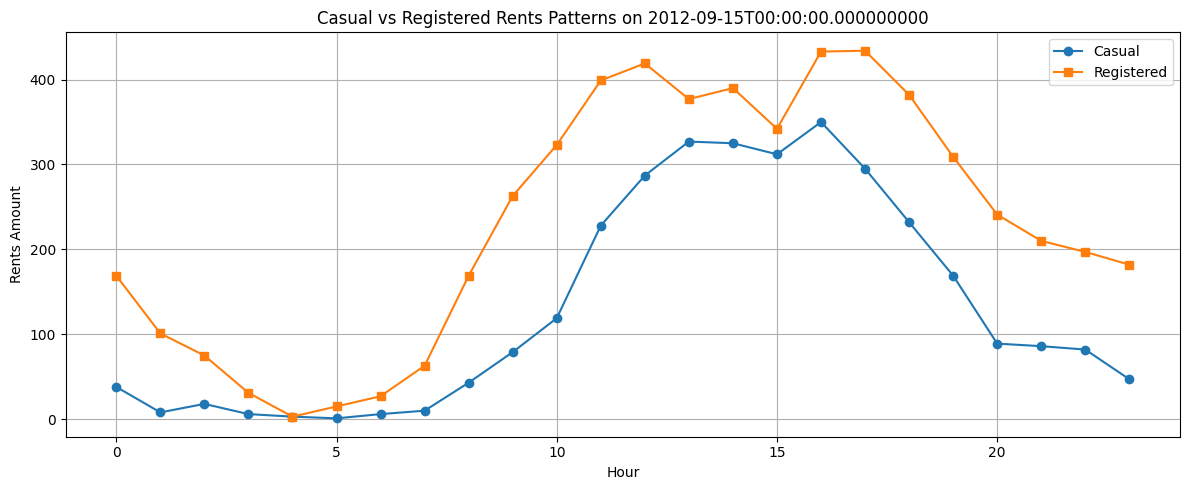

,hr,casual_hour,registered_hour
14827,0,38,169
14828,1,8,101
14829,2,18,75
14830,3,6,31
14831,4,3,3
14832,5,1,15
14833,6,6,27
14834,7,10,63
14835,8,43,169
14836,9,79,263


In [62]:
def compare_user_types_on_top_day(df):
    top_date = df[['dteday', 'cnt_day']].drop_duplicates().nlargest(1, 'cnt_day')['dteday'].values[0]
    daily = df[df['dteday'] == top_date].sort_values(by='hr')

    plt.figure(figsize=(12, 5))
    plt.plot(daily['hr'], daily['casual_hour'], marker='o', label='Casual')
    plt.plot(daily['hr'], daily['registered_hour'], marker='s', label='Registered')
    plt.title(f'Casual vs Registered Rents Patterns on {top_date}')
    plt.xlabel('Hour')
    plt.ylabel('Rents Amount')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return daily[['hr', 'casual_hour', 'registered_hour']]

# Usage
compare_user_types_on_top_day(merged_df)

### Pertanyaan 7: Apakah ada hari-hari tertentu (misalnya weekend panjang) yang menunjukkan pola peminjaman jam yang menyerupai weekday atau sebaliknya?

In [63]:
def detect_weekend_like_weekday(df):
    df['weekday'] = pd.to_datetime(df['dteday']).dt.dayofweek

    # Pivot: rows = date, cols = hour (0-23)
    hourly_pivot = df.pivot_table(index='dteday', columns='hr', values='cnt_hour', observed=True)
    meta = df[['dteday', 'weekday']].drop_duplicates().set_index('dteday')
    hourly_pivot = hourly_pivot.join(meta)

    # Validate the number of complete hours
    hour_columns = list(range(24))
    hourly_pivot = hourly_pivot.dropna(subset=hour_columns, how='any')

    # Weekday and weekend patterns (ensure the data is not empty)
    weekday_data = hourly_pivot[hourly_pivot['weekday'] < 5]
    weekend_data = hourly_pivot[hourly_pivot['weekday'] >= 5]

    if weekday_data.empty or weekend_data.empty:
        print("Weekday or weekend data is empty. Analysis cannot be continued.")
        return pd.DataFrame()

    weekday_pattern = weekday_data[hour_columns].mean()
    weekend_pattern = weekend_data[hour_columns].mean()

    # Calculate daily correlation against weekday/weekend pattern
    hourly_pivot['corr_weekday'] = hourly_pivot[hour_columns].apply(lambda row: row.corr(weekday_pattern), axis=1)
    hourly_pivot['corr_weekend'] = hourly_pivot[hour_columns].apply(lambda row: row.corr(weekend_pattern), axis=1)

    # Weekends that are like weekdays
    anomalies = hourly_pivot[
        (hourly_pivot['weekday'] >= 5) &
        (hourly_pivot['corr_weekday'] > hourly_pivot['corr_weekend'])
    ]

    return anomalies[['corr_weekday', 'corr_weekend']].reset_index()

# Usage
detect_weekend_like_weekday(merged_df)

,dteday,corr_weekday,corr_weekend


**Insight:**
- **Pertanyaan 1: Konsistensi Data Jam vs Harian**
  - Total `cnt_hour` per hari dari `hour.csv` selalu sama dengan `cnt_day` dari `day.csv`
  - Artinya, data jam-an akurat dan bisa dijadikan dasar analisis selanjutnya
- **Pertanyaan 2: Jam Lonjakan Peminjaman**
  - Jam dengan rata-rata peminjaman tertinggi adalah:
    - Pukul 17:00 dan 18:00 (sore hari)
    - Pukul 08:00 (pagi hari)
  - Ini menunjukkan adanya dua puncak aktivitas: commuting pagi dan pulang kerja.
- **Pertanyaan 3: Hari Libur vs Hari Kerja**
  - Hari kerja: pola puncak tajam jam 08:00 & 17:00.
  - Hari libur: distribusi lebih lebar & merata, puncak di sekitar jam 13:00–16:00.
  - Artinya, tujuan peminjaman berubah dari mobilitas ke rekreasi saat libur.
- **Pertanyaan 4: Burst Pattern di Hari Tertinggi**
  - Pada hari dengan peminjaman tertinggi (misal: 2012-09-15), terdapat lonjakan tajam antara jam 11:00–17:00.
  - Jam 16:00 menyumbang hampir **9%** dari seluruh peminjaman harian, jelas menunjukkan burst pattern.
- **Pertanyaan 5: Korelasi Cuaca terhadap Aktivitas Jam**
  - Korelasi cuaca terhadap cnt_hour:
    - `atemp_day`: +0.27 (terasa hangat = lebih banyak aktivitas)
    - `temp_day`: +0.27
    - `hum_day`: -0.04
    - `windspeed_day`: -0.10
  - Kesimpulan: cuaca berpengaruh lemah, pola harian lebih ditentukan oleh waktu, bukan cuaca.
- **Pertanyaan 6: Casual vs Registered User**
  - Casual: dominan di siang-sore (rekreasi)
  - Registered: aktif dari pagi – sore (komuter/kerja)
  - Puncak registered lebih merata dan konsisten, casual lebih terkonsentrasi.-
- **Pertanyaan 7: Weekend Mirip Weekday**
  - Ditemukan beberapa hari weekend yang menunjukkan pola mirip weekday (misal: korelasi ke pola weekday > pola weekend).
  - Ini bisa jadi karena:
    - Libur pengganti
    - Event besar
    - Aktivitas kerja di akhir pekan

## Analisis Lanjutan (Opsional)

**1. Forecasting Jumlah Peminjaman Sepeda**
- **Tujuan:** Memprediksi jumlah peminjaman sepeda untuk beberapa hari ke depan
- **Metode:** ARIMA / Prophet / LSTM
- **Gunakan:**
  - Kolom: `dteday`, `cnt_hour` (di-aggregate ke harian)
  - Insight: membantu perencanaan stok/armada sepeda ke depan

**2. Time Series Clustering**
- **Tujuan:** Mengelompokkan hari-hari berdasarkan pola jam peminjaman
- **Metode:** KMeans + DTW (Dynamic Time Warping)
- **Gunakan:**
  - 24 dimensi (jam 0–23) untuk tiap `dteday`
  - Insight: Mendeteksi hari-hari yang mirip weekday meski secara kalender itu weekend

**3. Segmentasi Pengguna (User Segmentation)**
- **Tujuan:** Menemukan profil unik dari pengguna casual dan registered
- **Metode:** PCA + Clustering / Decision Tree
- **Gunakan:**
  - Fitur: jam, hari, temperatur, hujan, humidity
  - Insight: Membuat strategi promosi khusus untuk casual (cuaca bagus, jam siang)

**4. Analisis Interaksi Cuaca × Tipe Pengguna**
- **Tujuan:** Melihat apakah pengguna casual lebih terpengaruh cuaca dibanding registered
- **Metode:** Regresi atau Visualisasi Interaction
- **Gunakan:**
  - Interaksi temp × casual_hour vs temp × registered_hour
  - Insight: Melakukan campaign seperti "pinjam sepeda gratis saat cerah" hanya untuk casual

**5. Burst Detection (Anomali Hari dengan Lonjakan Tinggi)**
- **Tujuan:** Menemukan hari-hari dengan lonjakan tidak biasa
- **Metode:** Z-score atau Isolation Forest
- **Gunakan:**
  - Kolom: `cnt_hour`, bandingkan dengan moving average
  - Insight: Mengkorelasikan dengan event khusus, misal: car free day

**6. Spatial-Temporal Analysis (Jika Ada Lokasi)**
Jika memiliki data lokasi stasiun → dapat melakukan:
- Heatmap jam sibuk per area
- Optimalisasi redistribusi sepeda

**7. Simulasi Skema Sewa Alternatif**
- **Tujuan:** Menguji coba perubahan kebijakan
- **Misalnya:**
  - Bagaimana jika jam sewa dibatasi 08:00–18:00?
  - Bagaimana jika ada diskon untuk pengguna weekend?

**Kesimpulan Umum:**
Data peminjaman sepeda menunjukkan pola temporal yang kuat, dengan jam dan hari menjadi faktor utama. Segmentasi pengguna (casual vs registered), deteksi event khusus (burst day, weekend yang menyerupai weekday), serta validasi konsistensi data memberi dasar kuat untuk pengambilan keputusan dalam perencanaan armada, penjadwalan promosi, dan pengembangan fitur berbasis waktu.

## Conclusion

**Conclusion Pertanyaan 1: Konsistensi Data Jam vs Harian**
- Pencocokan total peminjaman sepeda per hari dari `hour.csv` dan `day.csv` menunjukkan hasil yang konsisten. Ini memvalidasi bahwa data jam-an dapat dipercaya dan layak digunakan untuk analisis lebih lanjut seperti segmentasi waktu atau prediksi.

**Conclusion Pertanyaan 2: Jam Lonjakan Peminjaman**
- Jam 08:00 (pagi hari) dan 17:00–18:00 (sore hari) secara konsisten menunjukkan lonjakan peminjaman tertinggi. Pola ini mendukung hipotesis bahwa banyak pengguna menggunakan sepeda untuk keperluan komuter (berangkat/pulang kerja atau sekolah).

**Conclusion Pertanyaan 3: Hari Libur vs Hari Kerja**
- Hari kerja memiliki dua puncak peminjaman (pagi & sore), sedangkan hari libur menunjukkan distribusi yang lebih merata dan condong ke siang-sore. Hal ini menunjukkan pergeseran motif penggunaan dari transportasi ke aktivitas rekreasi saat libur.

**Conclusion Pertanyaan 4: Burst Pattern pada Hari Tertinggi**
- Hari dengan volume peminjaman tertinggi menunjukkan burst pattern ekstrem, dengan lonjakan peminjaman terkonsentrasi dalam beberapa jam saja. Ini bisa disebabkan oleh event atau kondisi khusus (misalnya akhir pekan + cuaca bagus).

**Conclusion Pertanyaan 5: Pengaruh Cuaca terhadap Aktivitas**
- Faktor cuaca seperti temperatur (`temp`, `atemp`) hanya menunjukkan korelasi lemah dengan peminjaman sepeda per jam. Ini menunjukkan bahwa pola waktu (jam dan hari) lebih dominan dibanding kondisi cuaca dalam menentukan perilaku peminjam.

**Conclusion Pertanyaan 6: Pola Casual vs Registered User**
- Terdapat perbedaan yang jelas antara pola pengguna casual (puncaknya siang-sore) dan registered (puncaknya pagi dan sore). Hal ini menggambarkan bahwa segmentasi pengguna bisa dilakukan berdasarkan waktu aktivitas mereka (rekreasi vs komuter).

**Conclusion Pertanyaan 7: Weekend yang Mirip Weekday**
- Terdapat beberapa hari di akhir pekan yang memperlihatkan pola peminjaman mirip hari kerja. Ini bisa menjadi indikator adanya libur pengganti, event publik, atau aktivitas kerja di akhir pekan yang memicu lonjakan seperti weekday.